# Store patterns efficiently

In [1]:
# Configure to show multiple value for development and debugging
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data

In [2]:
# two witnesses, with repetition and transposition

# Original example, single leaf node
w1 = '''the red and the black cat'''
w2 = '''the black and the red cat'''

# Adjacent transposition
# w1 = '''the red striped cat'''
# w2 = '''the striped red cat'''

# Two leaf nodes
# w1 = '''cat red black'''
# w2 = '''cat black red'''

# Branches meet in the middle at koala and then split again, with two leaf nodes
# w1 = """cat red black koala brown gray"""
# w2 = """cat black red koala gray brown"""

# Two split and rejoin
# w1 = '''the gray koala'''
# w2 = '''the brown koala'''

# medium example
# w1 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ much more from each other, than do the individuals of any one
# species or variety in a state of nature.'''
# w2 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ more from each other than do the individuals of any one
# species or variety in a state of nature.'''

# Larger example
# w1 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ much more from each other, than do the individuals of any one
# species or variety in a state of nature. When we reflect on the vast diversity of the
# plants and animals which have been cultivated, and which have varied during all ages
# under the most different climates and treatment, I think we are driven to conclude that
# this greater variability is simply due to our domestic productions having been raised
# under conditions of life not so uniform as, and somewhat different from, those to which
# the parent-species have been exposed under nature. There is, also, I think, some
# probability in the view propounded by Andrew Knight, that this variability may be partly
# connected with excess of food. It seems pretty clear that organic beings must be exposed
# during several generations to the new conditions of life to cause any appreciable amount
# of variation; and that when the organisation has once begun to vary, it generally
# continues to vary for many generations. No case is on record of a variable being ceasing
# to be variable under cultivation. Our oldest cultivated plants, such as wheat, still
# often yield new varieties: our oldest domesticated animals are still capable of rapid
# improvement or modification.'''
# w2 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ more from each other than do the individuals of any one
# species or variety in a state of nature. When we reflect on the vast diversity of the
# plants and animals which have been cultivated, and which have varied during all ages
# under the most different climates and treatment, I think we are driven to conclude that
# this great variability is simply due to our domestic productions having been raised
# under conditions of life not so uniform as, and somewhat different from, those to which
# the parent-species have been exposed under nature. There is also, I think, some
# probability in the view propounded by Andrew Knight, that this variability may be partly
# connected with excess of food. It seems pretty clear that organic beings must be exposed
# during several generations to the new conditions of life to cause any appreciable amount
# of variation; and that when the organisation has once begun to vary, it generally
# continues to vary for many generations. No case is on record of a variable being ceasing
# to be variable under cultivation. Our oldest cultivated plants, such as wheat, still
# often yield new varieties: our oldest domesticated animals are still capable of rapid
# improvement or modification'''

## Work plan

1. Create token array (Python **list**)
1. Create suffix array
1. Create LCP (**longest common prefix**) array
1. Calculate LCP intervals
1. Create patterns

## Construct list of ngrams shared by witnesses

Find ngrams and positions in witnesses

### Tokenize witnesses

In [3]:
def tokenize_witnesses(w1_string, w2_string):
    '''Return list of witnesses, each represented by a list of tokens'''
    # TODO: handle punctuation, upper- vs lowercase
    w1_tokens = w1.split()
    w2_tokens = w2.split()
    witnesses = [w1_tokens, w2_tokens]
    return witnesses

In [4]:
witnesses = tokenize_witnesses(w1, w2)
# print(witnesses) # take a look

In [5]:
# Create token array
# All tokens from both witnesses in a single list, with a separator (" # ") between witnesses
token_array = []
token_array.extend(witnesses[0])
token_array.append(" # ")
token_array.extend(witnesses[1])
# [(index, value) for index,value in enumerate(token_array)] # take a look

In [6]:
# determine suffixes of token array
# output with print() is diagnostic
# for index, token in enumerate(token_array):
#     suffix = token_array[index:]
#     print(suffix)

In [7]:
# suffix array is sorted alphabetically
# tuples of list of tokens (suffix) and position in original list of tokens
# TODO: less naive implementation
suffixes = []
for index, token in enumerate(token_array):
    suffix = token_array[index:]
    suffixes.append((suffix, index))
suffixes.sort() # sort in place
# suffixes # take a look

Notice that suffixes that start at position 2 and 9 both start with "and the", which tells us that:

1. There is a repeated suffix "and the"
1. "and" appears without "the"

Ergo, we don't need a unigram "and".

Similarly, other ngrams occur repeatedly: "the red" twice, "the" four times, etc. Occurrences of "and" are easy because they are only "and the", while "the" occurs in different contexts, e.g., twice in "the red", twice in "the black".

In [8]:
# suffix array is list of offsets of start positions of suffixes sorted alphabetically
# Suffix array is economical because it is equal to the sum of the lengths of witnesses plus the number of witnesses - 1 (for the separators)
suffix_array = []
for suffix, index in suffixes:
    suffix_array.append(index)
suffix_array # take a look [80:90]

[6, 2, 9, 8, 4, 12, 5, 1, 11, 7, 3, 0, 10]

In [9]:
# compute LCP array
# sequential pairs of values in suffix array, which are two offsets in the sorted suffixes
# for i in range(0, len(suffix_array) - 1):
#     print (suffix_array[i:i+2])

In [10]:
# compute LCP array, which is a sequence of integers representing the number of tokens shared by consecutive alphabetically sorted suffixes
# sequential pairs of values in suffix array, which are two offsets in the sorted suffixes
# TODO: we now need the longest prefix
lcp_array = [0]
for i in range(0, len(suffix_array) - 1): # for each pair of suffixes, retrieve list of tokens starting at that position
    pair = suffix_array[i:i+2] # for each pair of suffixes
    suffix_1 = token_array[pair[0]:] # tokens starting at first position
    suffix_2 = token_array[pair[1]:] # tokens starting at second position
    # print(suffix_1, suffix_2) # diagnostic: verify that they're paired correctly
    lcp_value = next(filter(lambda t: t[1][0] != t[1][1], enumerate(zip(suffix_1, suffix_2))), min(len(suffix_1), len(suffix_2))) # pair the tokens up by position, return (number of matches, first non-match)
    lcp_array.append(lcp_value[0] if type(lcp_value) == tuple else lcp_value) # most are tuples, but some are just an integer
# lcp_array # take a look

In [11]:
# Use LCP array to calculate patterns (efficiently)
# Values in LCP array represent lengths of matching ngrams
#   e.g., the three values of 2 are "and the", "the black", "the red"
#   "the" is harder: unigram appears four times, plus "the black" and "the red"
#
# Of interest:
#   1. 0 means that whatever follows will have nothing in common with it
#   2. Repetition of same number (doesn't happen here) means same pattern
#   3. Consecutive non-zero values identify how much of the pattern they have in common, 
#      e.g., end goes from "the black" (2) to "the" (1) to "the red" (2)
#         Counts are always +1, so there must be two instances of "the red", two of "the black", 
#      and four of "the" (two unigrams and two embedded in "the red" and "the black")

In [12]:
# create Block dataclass
from dataclasses import dataclass
@dataclass(unsafe_hash=True)
class Block:
    token_count: int
    start_position: int # offset into suffix array (not in token array!)
    end_position: int # start and end position give number of occurrences
    all_start_positions: [] # compute after blocks have been completed
    # witness_count: int # number of witnesses in which pattern occurs, omitted temporarily because requires further computation
    frequency: int # number of times pattern occurs in whole witness set (may be more than once in a witness), end_position - start_position + 1
    how_created: int # debug

In [13]:
# create blocks from the lcp array
from collections import deque # faster append and pop than list
blocks = []
open_block_stack = deque()
print(list(enumerate(lcp_array)))
for offset, lcp in enumerate(lcp_array):
    # three situations: next one is same value, higher that last, or lower than last
    # if same value: same pattern
    # if higher or lower, new pattern (may overlap with previous, unless one or the other value is 0)
    if offset == 0: # skip the first one, which is a transition from a fake start value
        continue # resume loop with next item in lcp array
    elif lcp == lcp_array[offset - 1]:
        pass # same pattern (happens with repetition), so do nothing
    elif lcp > lcp_array[offset - 1]: # new prefix is longer than previous one, so start new pattern
        # can fill in end_position and frequency only when we encounter a shorter value in the LCP array
        # start_position is number of patterns that are the same 
        open_block_stack.append(Block(token_count = lcp, start_position = offset - 1, end_position = -1, all_start_positions = [], frequency = -1, how_created = 1))
    else: # new prefix is shorter than previous one, so:
            # 1. close open blocks with higher values
            # 2. do something else
        while open_block_stack and open_block_stack[-1].token_count > lcp: # if an open block is longer than the current length, pop and close it
            block_being_modified = open_block_stack.pop()
            block_being_modified.end_position = offset - 1
            block_being_modified.frequency = block_being_modified.end_position - block_being_modified.start_position + 1
            blocks.append(block_being_modified)
        if lcp == 0: # if 0, stop after clearing the stack
            continue
        # not 0, and: either 1) stack is empty, or 2) top has an lcp value equal to current, or 3) an lcp value less than current
        if not open_block_stack: # stack is empty, so hidden shorter block; create new block that starts at start position of last closed block
            open_block_stack.append(Block(token_count = lcp, start_position = blocks[-1].start_position, end_position = -1, all_start_positions = [], frequency = -1, how_created = 2))
        elif open_block_stack[-1].token_count == lcp: # stack has value same length as current, so do nothing
            pass
        else: # stack has value less than current, so extends shorter block; create new block, but where?
            # TODO: why does this work?
            open_block_stack.append(Block(token_count = lcp, start_position = blocks[-1].start_position, end_position = -1, all_start_positions = [], frequency = -1, how_created = 3))
            # print(open_block_stack)
            # print(blocks[-1])
        # if equal to current length, do nothing; it's open, but we can't close it yet
while open_block_stack: # pop anything left in open_block_stack
    block_being_modified = open_block_stack.pop()
    block_being_modified.end_position = len(lcp_array) - 1
    block_being_modified.frequency = block_being_modified.end_position - block_being_modified.start_position + 1
    blocks.append(block_being_modified)

# for block in blocks: # diagnostic
#     # suffix_array is offsets of start positions of suffixes (in alphabetical order) into token_array
#     # block.start_position is offset of suffix into suffix_array, which is one less than offset into lcp_array
#     # we slice token_array:
#     #   start of slice is offset into token_array (by way of suffix_array by way of lcp_array) of first ngram token
#     #   length of slice adds the length of the lcp interval (part of lcp array that represents pattern, which = length of ngram) to the start of the slice
#     print(block)
#     print(token_array[suffix_array[block.start_position]:suffix_array[block.start_position] + block.token_count])
if open_block_stack: # diagnostic; should be empty
    print('ERROR: open_block_stack should be empty')
    print(open_block_stack)

[(0, 0), (1, 0), (2, 2), (3, 0), (4, 1), (5, 0), (6, 1), (7, 0), (8, 1), (9, 0), (10, 2), (11, 1), (12, 2)]


Block 1 starts at suffix_array position 1 and ends at 2. This means that tokens 2 (position 1) and 9 (position 2) are the (only) two start positions of the two instances of the bigram 'and the' in the token_array.

In [14]:
# If we enumerate the token array and look at tokens 2 and 9, we see the two instances of the bigram 'and the'.

# [(index, value) for index,value in enumerate(token_array)]

If we iterate over the blocks, for each block we can get its start position(s) in the token array and the ngrams themselves (not in token-array order, but we can sort later). We can then sort them by token position to get a list of ngrams for both witnesses in token order (which we need because we do our alignment from left to right). The token array doesn't distinguish the witnesses explicitly, but if we subtract the length of w1 from a position, add 1, and get a positive number, we're in w2.

In [15]:
# add all_start_tokens property value to blocks (initialized as empty list)
for index, block in enumerate(blocks): # compute all start tokens just once for each block
    _all_start_tokens = suffix_array[block.start_position: block.end_position + 1]
    _all_start_tokens.sort()
    block.all_start_positions = _all_start_tokens # save it to the block

# blocks # take a look

In [16]:
# use blocks to create separate list of matches
#
# block contain all_start_positions property, which lists ... wait for it ... all start positions of ngram
# we can get the length of w1 from witnesses[0], so we can tell which start positions are in w1, and the others are in w2
# we create all matches by pairing each w1 start position with each w2 start position in the same block
#
from itertools import product as cartesian_product # all combinations of members in two lists
from typing import List
w1_length = len(witnesses[0])
#
@dataclass(unsafe_hash=True)
class Match:
    '''unique combination of ngram length and positions in the two witnesses

    In case an ngram repeats in a witness, create a separate match for each combination of each instance
    E.g., if an ngram occurs twice in each witness, create four matches
    '''
    __slots__ = ['ngram', 'token_count', 'w1_start_position', 'w1_end_position', 'w2_start_position', 'w2_end_position']
    ngram: str # combine tokens into single string to make it hashable
    token_count: int
    w1_start_position: int
    w1_end_position: int
    w2_start_position: int
    w2_end_position: int
#
matches = []
for block in blocks:
    _ngram = " ".join(token_array[block.all_start_positions[0]:block.all_start_positions[0] + block.token_count])
    start_positions = block.all_start_positions
    w1_start_positions = list(filter(lambda x: x < w1_length, start_positions))
    w2_start_positions = list(filter(lambda x: x not in w1_start_positions, start_positions))
    match_pairs = cartesian_product(w1_start_positions, w2_start_positions)
    matches.extend([Match(ngram = _ngram, \
                          token_count = block.token_count, \
                          w1_start_position = match_pair[0], \
                          w1_end_position = match_pair[0] + block.token_count - 1, \
                          w2_start_position = match_pair[1], \
                          w2_end_position = match_pair[1] + block.token_count - 1) for match_pair in match_pairs])
# matches # take a look

In [17]:
# (cf cell #13 in decision_graph_3 notebook)
# sort matches by witness A
# column labels, ordered by w1 pos, then w2 pos, then ngram length (long to short)
# patterns_A = [] # will need to be sorted after all values have been added
# for k, v in alignments.items():
#     for ngram in v: # add instance of dataclass Pattern for each ngram at A,B positions
#         current_ngram_length = ngram_lengths[ngram]
#         patterns_A.append(Pattern(k[0], k[1], ngram, current_ngram_length, k[0] + current_ngram_length - 1, k[1] + current_ngram_length - 1))
patterns_A = sorted(matches, key=lambda x: (x.w1_start_position, x.w2_start_position, -x.token_count))
patterns_A.insert(0, Match(w1_start_position = -1, \
                           w1_end_position = -1, \
                           w2_start_position = -1, \
                           w2_end_position = -1, \
                           ngram = 'ROOT', token_count = 1))

# patterns_A # take a look

In [18]:
# (cf cell #14 in decision_graph_3 notebook)
# sort also by witness B
patterns_B = sorted(patterns_A, key=lambda x: (x.w2_start_position, x.w1_start_position, -x.token_count))

# patterns_B # take a look

In [19]:
# find and save all diagonal patterns in list
# TODO: can we use a copy constructor to avoid having to copy all of the properties individually?
diagonal_patterns = []
for table_offset_A, pattern in enumerate(patterns_A): # find table offset for each A pattern
    if patterns_B[table_offset_A] is pattern: # is the pattern at the same offset in B the same object?
        diagonal_patterns.append(pattern) # if so, it's a diagonal
# diagonal_patterns # take a look

In [20]:
# Node objects contain unique id values plus pattern (not token) coordinates for both witnesses
@dataclass(unsafe_hash=True)
class Decision_Graph_Node:
    __slots__ = ['id', 'pattern_coordinate_witness_A', 'pattern_coordinate_witness_B']
    id: int
    pattern_coordinate_witness_A: int # offset into list of patterns (not the same as token coordinate)
    pattern_coordinate_witness_B: int
    # score: int # count of aligned tokens, or should that be on the edges?

In [21]:
# First create root node
root = Decision_Graph_Node(0, 0, 0)

In [22]:
def find_diagonal_pattern_for_node(current_node : Decision_Graph_Node):
    # go over the diagional patterns and find the first pattern that begins after the end token of the current pattern.
    current_pattern_A = patterns_A[current_node.pattern_coordinate_witness_A] # offset into list of patterns
    current_pattern_B = patterns_B[current_node.pattern_coordinate_witness_B]

    next_diagonal_pattern = next(filter(lambda dp: dp.w1_start_position > current_pattern_A.w1_end_position and dp.w2_start_position > current_pattern_B.w2_end_position, diagonal_patterns), None)
    return next_diagonal_pattern

# next_pattern_in_both = find_diagonal_pattern_for_node(root)
# next_pattern_in_both

In [23]:
from typing import Set

@dataclass(unsafe_hash=True)
class Decision_Graph_Edge:
    __slots__ = ['source', 'target']
    source: int
    target: int

@dataclass
class Decision_Graph: # set of nodes
    __slots__ = ['nodes', 'edges']
    nodes: Set[Decision_Graph_Node]
    edges: Set[Decision_Graph_Edge]

decision_graph_nodes = {root} # set of nodes
decision_graph_edges = set()
decision_graph = Decision_Graph(decision_graph_nodes, decision_graph_edges)
# decision_graph # take a look; so far just one node (root) and no edges

In [24]:
# stable lookup for index position of pattern in witness-specific lists of patterns
patterns_A_position_by_value = {val: index for index, val in enumerate(patterns_A)} # retrieve offset in witness-specific list of patterns by pattern
patterns_B_position_by_value = {val: index for index, val in enumerate(patterns_B)} # retrieve offset in witness-specific list of patterns by pattern
# patterns_A_position_by_value # WTF: take a look ... to know where to start computing diagonal ... perhaps???

In [25]:
# Dictionary to check whether node has already been added for a pattern:
#
# If the node has already been added, don't add a new node, but retrieve the node id to add a new edge
# If the node has not already been added, add it, along with an edge

node_finder = {} # dictionary; key is pattern coordinate A, value is node id
node_finder[0] = 0

In [26]:
# Recursive function to add all nodes to graph in depth-first-order
# Starts from root, with has already been added manually
from typing import List
# Ror each node we create at most three children plus edges (or just edges if a child node already exists):
#
#   1. Next pattern in Witness A. Look for the same pattern in Witness B. Should not be a diagional, see below.
#   2. Next pattern in Witness B. Look for the same pattern in Witness A. Should not be a diagional, see below.
#   3. Next pattern on a diagional. Could result in a skip of the patterns mentioned above.

# function to identify and add all children of specified node
# TODO: do not create child if it already exists
def add_children(parent: Decision_Graph_Node): # find and create children of input (parent), returns nothing
    # BUG: we currently exclude diagonals from closest in A and B incorrectly; diagonals are from the parent at each step, and not invariably from the root
    # find closest in A and B that are not also diagonals and create node plus edge (or just edge, if node has already been added)
    # find closest diagonal and create node (or just edge, if node has already been added)
    pattern_A = patterns_A[parent.pattern_coordinate_witness_A] # offset of parent Pattern in list of patterns ordered by witness A
    token_coordinate_witness_A = pattern_A.w1_end_position # ending token position of parent in witness A
    token_coordinate_witness_B = pattern_A.w2_end_position
    next_A_pattern = next(filter(lambda x : x.w1_start_position > token_coordinate_witness_A and x.w2_start_position > token_coordinate_witness_B \
                               and x not in diagonal_patterns, patterns_A[parent.pattern_coordinate_witness_A:]), None) # first pattern after parent token position
    next_B_pattern = next(filter(lambda x : x.w1_start_position > token_coordinate_witness_A and x.w2_start_position > token_coordinate_witness_B \
                               and x not in diagonal_patterns, patterns_B[parent.pattern_coordinate_witness_B:]), None) # first pattern after parent token position
    next_diag_pattern = find_diagonal_pattern_for_node(parent)

    if next_A_pattern:
        next_A_pattern_index_A = patterns_A_position_by_value[next_A_pattern]
        next_A_pattern_index_B = patterns_B_position_by_value[next_A_pattern]

        if not next_A_pattern_index_A in node_finder: # add new node only if it hasn't already been added
            new_node_id = len(decision_graph.nodes)
            first_node = Decision_Graph_Node(new_node_id, next_A_pattern_index_A, next_A_pattern_index_B) # create new node
            decision_graph_nodes.add(first_node)
            node_finder[next_A_pattern_index_A] = new_node_id # and update node finder
            edge1 = Decision_Graph_Edge(parent.id, first_node.id) # add edge to newly created node
            decision_graph_edges.add(edge1)
            add_children(first_node)
        else:
            edge1 = Decision_Graph_Edge(parent.id, node_finder[next_A_pattern_index_A]) # add new edge to pre-existing node
            decision_graph_edges.add(edge1)

    if next_B_pattern:
        next_B_pattern_index_A = patterns_A_position_by_value[next_B_pattern]
        next_B_pattern_index_B = patterns_B_position_by_value[next_B_pattern]

        if not next_B_pattern_index_A in node_finder:
            new_node_id = len(decision_graph.nodes)
            second_node = Decision_Graph_Node(new_node_id, next_B_pattern_index_A, next_B_pattern_index_B)
            decision_graph_nodes.add(second_node)
            node_finder[next_B_pattern_index_A] = new_node_id
            edge2 = Decision_Graph_Edge(parent.id, second_node.id)
            decision_graph_edges.add(edge2)
            add_children(second_node)
        else:
            edge2 = Decision_Graph_Edge(parent.id, node_finder[next_B_pattern_index_A])
            decision_graph_edges.add(edge2)

    if next_diag_pattern:
        next_diag_pattern_index_A = patterns_A_position_by_value[next_diag_pattern]
        next_diag_pattern_index_B = patterns_B_position_by_value[next_diag_pattern]

        if not next_diag_pattern_index_A in node_finder:
            new_node_id = len(decision_graph.nodes)
            third_node = Decision_Graph_Node(new_node_id, next_diag_pattern_index_A, next_diag_pattern_index_B)
            decision_graph_nodes.add(third_node)
            node_finder[next_diag_pattern_index_A] = new_node_id
            edge3 = Decision_Graph_Edge(parent.id, third_node.id)
            decision_graph_edges.add(edge3)
            add_children(third_node)
        else:
            edge3 = Decision_Graph_Edge(parent.id, node_finder[next_diag_pattern_index_A])
            decision_graph_edges.add(edge3)

# Populate the graph (all nodes and edges)
add_children(root) # builds entire decision graph recursively

In [27]:
# decision_graph # take a look

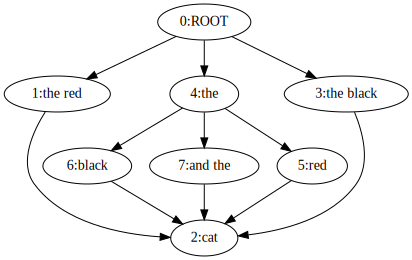

In [28]:
# visualize decision graph
import graphviz
from IPython.display import SVG

# node id values must be strings for graphviz
a = graphviz.Digraph(format="svg")
for item in decision_graph.nodes: # set of Decision_Graph_Node objects, call it "item" to avoid overusing the keyword "node"
    a.node(str(item.id), label=str(item.id) + ':' + patterns_A[item.pattern_coordinate_witness_A].ngram)
for item in decision_graph.edges:
    a.edge(str(item.source), str(item.target))
SVG(a.view())

### Non-OO Python implementation of Kahn's topological sort algorithm

https://algocoding.wordpress.com/2015/04/05/topological-sorting-python/

In [29]:
# convert set of edges to adjacency list, preparatory to topological sorting
from collections import defaultdict
adjacency_list = defaultdict(list) # key is source, value is list of targets
for edge in decision_graph.edges:
    adjacency_list[edge.source].append(edge.target)
    if edge.target not in adjacency_list: # adjacency list needs a key for every node, even if 
        adjacency_list[edge.target] = []
# adjacency_list # take a look

In [30]:
# copied from https://algocoding.wordpress.com/2015/04/05/topological-sorting-python/

from collections import deque

def kahn_topsort(graph):
    in_degree = { u : 0 for u in graph }     # determine in-degree
    for u in graph:                          # of each node
        for v in graph[u]:
            in_degree[v] += 1

    Q = deque()                 # collect nodes with zero in-degree
    for u in in_degree:
        if in_degree[u] == 0:
            Q.appendleft(u)

    L = []     # list for order of nodes

    while Q:
        u = Q.pop()          # choose node of zero in-degree
        L.append(u)          # and 'remove' it from graph
        for v in graph[u]:
            in_degree[v] -= 1
            if in_degree[v] == 0:
                Q.appendleft(v)

    if len(L) == len(graph):
        return L
    else:                    # if there is a cycle,
        return []            # then return an empty list

In [31]:
order = kahn_topsort(adjacency_list)
# print(order) # take a look

In [32]:
# dictionary to retrieve parent by child
parent_by_child = defaultdict(list)
for k, v in adjacency_list.items():
    for node in v:
        parent_by_child[node].append(k)
# parent_by_child # take a look

In [33]:
# traverse in topological order to find best path
# for each node, track cumulative score (token score plus best token count of parents) and best parent
# may be ties for best score / parent

from typing import List

@dataclass
class Score:
    __slots__ = ['total', 'parent']
    total: int # best cumulative total
    parent: List[int] # node id

scores = {}
scores[0] = Score(total = 0, parent = []) # add root manually

# scores # take a look

In [34]:
# Dictionary to retrieve node by id
# Sigh ... another dictionary!
node_by_id = {}
for node in decision_graph.nodes:
    node_by_id[node.id] = node
# node_by_id # take a look

In [35]:
# score all nodes, keep track of best cumulative score
best_score = 0 # best cumulative score for all nodes
for node in order[1:]: # skip root; already done
    local_ngram_count = patterns_A[node_by_id[node].pattern_coordinate_witness_A].token_count # ngram token count for current node
    parents = parent_by_child[node] # all parents
    best_parent_score = 0
    best_parents = [] # parents with highest score
    for parent in parents:
        current_parent_score = scores[parent].total
        if current_parent_score > best_parent_score: # replace old best score and parent pointers
            best_parent_score = current_parent_score
            best_parents = [parent]
        elif current_parent_score == best_parent_score: # tie for best parent, so add to list
            best_parents.append(parent)
    scores[node] = Score(total = best_parent_score + local_ngram_count, parent = best_parents)
    if scores[node].total > best_score: # if new score is highest of all so far, update best_score
        best_score = scores[node].total
# print(scores) # take a look at all scores,
# print(best_score) # and at best score

In [36]:
# there will be exactly one or exactly two best leaves, return as list
best_leaves = [k for k,v in scores.items() if v.total == best_score] # id(s) of leaves with best cumulative score
# best_leaves # take a look at leaves with best score

# Work plan

1. Traverse backward from best leaf (choose one) to find best path (choose one)
1. Build and render variant graph (no transpositions yet)
1. Find transpositions and add to variant graph; visualize variant graph with transpositions
1. Visualize alignment as table
1. Perhaps: Find all best paths, instead of just one

In [37]:
# function to traverse backward from best leaf to find best path
# arbitrarily chooses one path in case of ties
def find_best_path(node: int) -> list: # start at leaf
    path = find_next_path_step([node]) # beginning of path as list, end of list is most recent step
    return path

def find_next_path_step(_path:list) -> list:
    if scores[_path[-1]].parent: # does last step (end of list) have a parent?
        next_step = scores[_path[-1]].parent[0] # if so, add first of its parents to end list
        _path.append(next_step)
        return find_next_path_step(_path) # now look for the next step up the chain
    else: # if no parent, we're at the root
        return _path

In [38]:
# find a best path from root to leaf
best_path = find_best_path(best_leaves[0]) # arbitrarily choose first if there are two best leaves
best_path.reverse() # built backward from leaf, so reverse in place (no return)
print(best_path) # take a look

[0, 4, 7, 2]


In [39]:
# create variant graph
# we have a list of aligned ngrams, but not of aligned tokens, so we need to look up the tokens
@dataclass
class Variant_Graph_Node: # text can be retrieved from token, since no normalization (yet)
    id: int
    token_positions: defaultdict(int)

@dataclass
class Variant_Graph_Edge:
    source: int
    target: int

@dataclass
class Variant_Graph:
    nodes: Set[Variant_Graph_Node]
    edges: Set[Variant_Graph_Edge]

In [40]:
# create the graph and the start and end nodes
variant_graph = Variant_Graph(nodes=[], edges=[])
max_token_pos = max({len(witness) for witness in witnesses}) # 1 greater than position of last token in longest witness
variant_graph_start = Variant_Graph_Node(id=0, token_positions={'A': -1, 'B': -1})
variant_graph_end = Variant_Graph_Node(id=1, token_positions={'A': max_token_pos, 'B': max_token_pos})
variant_graph.nodes.append(variant_graph_start)
variant_graph.nodes.append(variant_graph_end)

# to add first witness, create a variant-graph node for each token in the witness
# create pointer from token_position_A to node
# create pointer from variant graph node id to the node itself
# create edges from each token in A to the next
variant_graph_node_by_token_position_A = {}
variant_graph_node_by_id = {}
variant_graph_node_by_id[0] = variant_graph_start
variant_graph_node_by_id[1] = variant_graph_end
most_recent_variant_graph_node_id = 0
variant_graph_edge_target_by_source = {}
for index, token in enumerate(witnesses[0]):
    id = len(variant_graph.nodes)
    new_variant_graph_node = Variant_Graph_Node(id=id, token_positions = {'A': index})
    variant_graph.nodes.append(new_variant_graph_node)
    variant_graph_node_by_token_position_A[index] = id
    variant_graph_node_by_id[id] = new_variant_graph_node

    variant_graph.edges.append(Variant_Graph_Edge(source=most_recent_variant_graph_node_id , target=id))
    variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] = id
    most_recent_variant_graph_node_id = id

variant_graph.edges.append(Variant_Graph_Edge(source=most_recent_variant_graph_node_id, target=variant_graph_end.id)) # add edge from last A node to end node
variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] = variant_graph_end.id
variant_graph.nodes # take a look
# variant_graph.edges
# variant_graph_node_by_token_position_A
# variant_graph_node_by_id
# variant_graph_edge_target_by_source
# print(len(variant_graph.nodes), 'nodes;', len(variant_graph.edges), 'edges')

[Variant_Graph_Node(id=0, token_positions={'A': -1, 'B': -1}),
 Variant_Graph_Node(id=1, token_positions={'A': 6, 'B': 6}),
 Variant_Graph_Node(id=2, token_positions={'A': 0}),
 Variant_Graph_Node(id=3, token_positions={'A': 1}),
 Variant_Graph_Node(id=4, token_positions={'A': 2}),
 Variant_Graph_Node(id=5, token_positions={'A': 3}),
 Variant_Graph_Node(id=6, token_positions={'A': 4}),
 Variant_Graph_Node(id=7, token_positions={'A': 5})]

In [41]:
node_by_id # diagnostic

{2: Decision_Graph_Node(id=2, pattern_coordinate_witness_A=10, pattern_coordinate_witness_B=10),
 1: Decision_Graph_Node(id=1, pattern_coordinate_witness_A=2, pattern_coordinate_witness_B=6),
 0: Decision_Graph_Node(id=0, pattern_coordinate_witness_A=0, pattern_coordinate_witness_B=0),
 4: Decision_Graph_Node(id=4, pattern_coordinate_witness_A=1, pattern_coordinate_witness_B=1),
 3: Decision_Graph_Node(id=3, pattern_coordinate_witness_A=6, pattern_coordinate_witness_B=2),
 6: Decision_Graph_Node(id=6, pattern_coordinate_witness_A=9, pattern_coordinate_witness_B=4),
 7: Decision_Graph_Node(id=7, pattern_coordinate_witness_A=5, pattern_coordinate_witness_B=5),
 5: Decision_Graph_Node(id=5, pattern_coordinate_witness_A=4, pattern_coordinate_witness_B=9)}

In [42]:
patterns_A # diagnostic

[Match(ngram='ROOT', token_count=1, w1_start_position=-1, w1_end_position=-1, w2_start_position=-1, w2_end_position=-1),
 Match(ngram='the', token_count=1, w1_start_position=0, w1_end_position=0, w2_start_position=7, w2_end_position=7),
 Match(ngram='the red', token_count=2, w1_start_position=0, w1_end_position=1, w2_start_position=10, w2_end_position=11),
 Match(ngram='the', token_count=1, w1_start_position=0, w1_end_position=0, w2_start_position=10, w2_end_position=10),
 Match(ngram='red', token_count=1, w1_start_position=1, w1_end_position=1, w2_start_position=11, w2_end_position=11),
 Match(ngram='and the', token_count=2, w1_start_position=2, w1_end_position=3, w2_start_position=9, w2_end_position=10),
 Match(ngram='the black', token_count=2, w1_start_position=3, w1_end_position=4, w2_start_position=7, w2_end_position=8),
 Match(ngram='the', token_count=1, w1_start_position=3, w1_end_position=3, w2_start_position=7, w2_end_position=7),
 Match(ngram='the', token_count=1, w1_start_po

# RESUME HERE

1. Decision graph is correct. Error (well, *first* error) is in building variant graph, below
2. Can we work collaboratively in PyCharm, and thus break the notebook into modules

In [43]:
# what we want to have: is a mapping from witness B tokens to nodes in the variant graph
# What we have (or can easily derive):
# A mapping from tokens in witness B to tokens in withness A
# A mapping from tokens in witness A to variant-graph nodes
#
# To get the mapping from tokens A to tokens B we have to go over the alignment path calculated above.
# for each item in the path we have a Pattern with two offsets.
# We need to convert that into a set of tokens from B mapped to tokens in A

tokens_in_A_by_B = {} # use B token position to retrieve A token position

for path_node_number in best_path: # best_path is list of node ids, which can be used to find patterns
    current_node = node_by_id[path_node_number]
    current_pattern = patterns_A[current_node.pattern_coordinate_witness_A] # stores start and end positions for both witnesses
    token_position_range_A = range(current_pattern.w1_start_position, current_pattern.w1_end_position + 1)
    token_position_range_B = range(current_pattern.w2_start_position - w1_length - 1, current_pattern.w2_end_position - w1_length - 1 + 1)
    pairs = list(zip(token_position_range_A,token_position_range_B))
    ngram = current_pattern.ngram
    for pair in pairs:
        tokens_in_A_by_B[pair[1]] = pair[0]

tokens_in_A_by_B # take a look

{-8: -1, 0: 0, 2: 2, 3: 3, 5: 5}

In [44]:
# loop over tokens in B
# if token is aligned and already present in A, update properties of variant graph node
# otherwise create new node
most_recent_variant_graph_node_id = 0 # source of first edge
for index, token in enumerate(witnesses[1]): # each token in B
    node_id_to_work_on = -1
    if index in tokens_in_A_by_B: # token is aligned and already present for A
        current_variant_graph_node_id = variant_graph_node_by_token_position_A[tokens_in_A_by_B[index]]
        variant_graph_node_by_id[current_variant_graph_node_id].token_positions['B'] = index
        node_id_to_work_on = current_variant_graph_node_id
    else: # not in A, so add new node
        id = len(variant_graph.nodes)
        new_variant_graph_node = Variant_Graph_Node(id=id, token_positions = {'B': index})
        variant_graph.nodes.append(new_variant_graph_node)
        variant_graph_node_by_id[id] = new_variant_graph_node
        node_id_to_work_on = id

    # now we process the edge
    if most_recent_variant_graph_node_id in variant_graph_edge_target_by_source and variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] == node_id_to_work_on: # already exists
        pass
    else: #create it
        variant_graph.edges.append(Variant_Graph_Edge(source=most_recent_variant_graph_node_id , target=node_id_to_work_on))
        variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] = node_id_to_work_on
    most_recent_variant_graph_node_id = node_id_to_work_on

if most_recent_variant_graph_node_id in variant_graph_edge_target_by_source and not variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] == variant_graph_end.id:
    variant_graph.edges.append(Variant_graph_edge(source=most_recent_variant_graph_node_id, target=variant_graph_end.id)) # add edge from last B node to end node

variant_graph.nodes
variant_graph.edges

[Variant_Graph_Node(id=0, token_positions={'A': -1, 'B': -1}),
 Variant_Graph_Node(id=1, token_positions={'A': 6, 'B': 6}),
 Variant_Graph_Node(id=2, token_positions={'A': 0, 'B': 0}),
 Variant_Graph_Node(id=3, token_positions={'A': 1}),
 Variant_Graph_Node(id=4, token_positions={'A': 2, 'B': 2}),
 Variant_Graph_Node(id=5, token_positions={'A': 3, 'B': 3}),
 Variant_Graph_Node(id=6, token_positions={'A': 4}),
 Variant_Graph_Node(id=7, token_positions={'A': 5, 'B': 5}),
 Variant_Graph_Node(id=8, token_positions={'B': 1}),
 Variant_Graph_Node(id=9, token_positions={'B': 4})]

[Variant_Graph_Edge(source=0, target=2),
 Variant_Graph_Edge(source=2, target=3),
 Variant_Graph_Edge(source=3, target=4),
 Variant_Graph_Edge(source=4, target=5),
 Variant_Graph_Edge(source=5, target=6),
 Variant_Graph_Edge(source=6, target=7),
 Variant_Graph_Edge(source=7, target=1),
 Variant_Graph_Edge(source=2, target=8),
 Variant_Graph_Edge(source=8, target=4),
 Variant_Graph_Edge(source=5, target=9),
 Variant_Graph_Edge(source=9, target=7)]

In [45]:
# create adjacency list for variant graph
variant_graph_adjacency_list = defaultdict(list) # key is source, value is list of targets
for edge in variant_graph.edges:
    variant_graph_adjacency_list[edge.source].append(edge.target)
    if edge.target not in variant_graph_adjacency_list: # adjacency list needs a key for every node, even if 
        variant_graph_adjacency_list[edge.target] = []
# variant_graph_adjacency_list # take a look

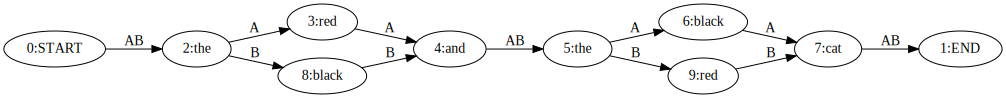

In [46]:
a = graphviz.Digraph(format="svg")
a.graph_attr['rankdir'] = 'LR'
for item in variant_graph.nodes: # set of Node objects, call it "item" to avoid overusing the keyword "node"
    if item.id == 0:
        ngram = 'START'
    elif item.id== 1:
        ngram = 'END'
    elif 'A' in item.token_positions:
        ngram = witnesses[0][item.token_positions['A']]
    elif 'B' in item.token_positions:
        ngram = witnesses[1][item.token_positions['B']]
    else:
        ngram = 'ERROR'
    a.node(str(item.id), label=str(item.id) + ':' + ngram)
for item in variant_graph.edges:
    outgoing_edge_targets = variant_graph_adjacency_list[item.source]
    if len(outgoing_edge_targets) == 1: # if there is one edge, get its label from its source
        label = "".join(variant_graph.nodes[item.source].token_positions.keys())
    else: # there are two edges, so two possible cases
        outgoing_edge_target_counts = sum([len(variant_graph_node_by_id[target_node].token_positions) for target_node in variant_graph_adjacency_list[item.source]]) # 2 in simple case, 3 in dificult one
        if outgoing_edge_target_counts == 2: # easy case; each target has one witness
            label = "".join([k for k, v in variant_graph_node_by_id[item.target].token_positions.items()]) # ugly way to retrieve a single siglum
        else: # difficult case; one target has one witness and one has two; which is which?
            node_with_two_witnesses = outgoing_edge_targets[0] if len(variant_graph_node_by_id[outgoing_edge_targets[0]].token_positions) == 2 else outgoing_edge_targets[1]
            node_with_one_witness = outgoing_edge_targets[0] if len(variant_graph_node_by_id[outgoing_edge_targets[0]].token_positions) == 1 else outgoing_edge_targets[1]
            single_witness_label = [k for k,v in variant_graph_node_by_id[node_with_one_witness].token_positions.items()][0] # ugly way to get only key as string value
            difficult_label = ({'A', 'B'} - {single_witness_label})
            if item.target == node_with_two_witnesses:
                label = difficult_label.pop() # get the lone set member as a string
            else:
                label = single_witness_label
    a.edge(str(item.source), str(item.target), label=label)
SVG(a.view())